# LIBRARIES

In [1]:
import os
import warnings

# Custom imports
from constants import ALPHA, RANDOM_STATE
from functions import best_features_set

import random
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import friedmanchisquare, shapiro, wilcoxon

from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer

from joblib import load

from imblearn.metrics import geometric_mean_score

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# SEED

In [2]:
# Setting the seed in the random module
random.seed(RANDOM_STATE)

# Setting the seed in the numpy module
np.random.seed(RANDOM_STATE)

# READ FILES

In [3]:
X_train = pd.read_csv('../dataset/X_train.csv', index_col=0)
y_train = pd.read_csv('../dataset/y_train.csv', index_col=0)

# READ MODELS

In [4]:
# Initialize the dictionary
models = {}

# Set the models folder path containing the model files
models_folder = '../models/'

# List all files in the main directory
files = os.listdir(models_folder)

# Iterate over the files in the directory
for file in files:
    file_path = os.path.join(models_folder, file)   
    
    # Extract the model name from the file name
    model_name = os.path.splitext(file)[0]
    
    # Add the model to the dictionary with the model name
    models[model_name] = joblib.load(file_path)

# RESULTS

The code provided below implements a model evaluation process using cross-validation. It iterates through a list of model names and conducts cross-validation for each model. Depending on the model name, the training data is preprocessed accordingly, and the resulting metrics, such as accuracy, precision, recall, F1 score, and ROC AUC, are gathered for each model. These evaluation results are then stored in a dictionary named "results." This code efficiently evaluates multiple models and provides a comprehensive understanding of their performance on the dataset.

In [5]:
# Define a custom scorer for geometric mean
gmean_scorer = make_scorer(geometric_mean_score)

scoring = {
    'precision': 'precision',
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'f1': 'f1',
    'gmean': gmean_scorer
}

results = {}

for model_name in models:
    
    # Get the features
    features = models[model_name].feature_names_in_
    
    print(model_name, features) 
    
    cv_results = cross_validate(
        models[model_name], 
        X_train.loc[:,features], 
        y_train.values.ravel(), 
        cv=RepeatedStratifiedKFold(random_state=RANDOM_STATE), 
        scoring=scoring
    )
    
    results[model_name] = {
        'precision': cv_results['test_precision'],
        'accuracy': cv_results['test_accuracy'],
        'roc_auc': cv_results['test_roc_auc'],
        'recall': cv_results['test_recall'],
        'f1': cv_results['test_f1'],
        'gmean': cv_results['test_gmean']
    }

NB ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
GB ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
DT ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
RF ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
SVM ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
LR ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']
MLP ['KATZ' 'MNA-SF' 'Hemoglobin' 'Leukocyte' 'Advanced Staging']


## - Summary

A comprehensive summary of the model performance is provided in the form of a dataframe that includes the relevant performance metrics.

In [6]:
# Creating a list of results for each model
all_results = []
for model_name in results:
    # Creating a list of dictionaries containing the means and standard deviations of each metric for the current model
    data = []
    for metric in ['precision', 'accuracy', 'roc_auc', 'recall', 'f1', 'gmean']:
        mean = results[model_name][metric].mean()
        std = results[model_name][metric].std()
        data.append({'Model': model_name, 'Metric': metric, 'Mean_Std': f'{mean:.4f} ± {std:.4f}'})
        
    # Creating a DataFrame from the data for the current model
    df = pd.DataFrame(data)
    
    # Adding the DataFrame for the current model to the list of results
    all_results.append(df)

# Concatenating all the DataFrames into a single DataFrame
results_df = pd.concat(all_results, axis=0)

# Setting the index to the name of the model
results_df.set_index('Model', inplace=True)

# Reorganizing the DataFrame
results_df = results_df.pivot(columns='Metric', values='Mean_Std')

# Displaying the DataFrame with the metrics in the desired order
results_df.loc[:,['accuracy', 'precision', 'recall', 'gmean', 'f1', 'roc_auc']]

Metric,accuracy,precision,recall,gmean,f1,roc_auc
Model,,,,,,
DT,0.6796 ± 0.0917,0.4441 ± 0.1319,0.6714 ± 0.1835,0.6636 ± 0.1104,0.5226 ± 0.1278,0.6843 ± 0.1071
GB,0.7858 ± 0.0766,0.6239 ± 0.1657,0.6371 ± 0.1490,0.7229 ± 0.0901,0.6120 ± 0.1139,0.8112 ± 0.0786
LR,0.7790 ± 0.0716,0.5779 ± 0.1220,0.7429 ± 0.1457,0.7608 ± 0.0824,0.6404 ± 0.1062,0.8447 ± 0.0758
MLP,0.7839 ± 0.0698,0.5861 ± 0.1193,0.7314 ± 0.1389,0.7610 ± 0.0818,0.6419 ± 0.1039,0.8493 ± 0.0701
NB,0.7710 ± 0.0994,0.5783 ± 0.1437,0.7343 ± 0.1340,0.7518 ± 0.0969,0.6356 ± 0.1141,0.8560 ± 0.0737
RF,0.7841 ± 0.0645,0.5945 ± 0.1251,0.7286 ± 0.1378,0.7584 ± 0.0705,0.6413 ± 0.0896,0.8178 ± 0.0775
SVM,0.6231 ± 0.1118,0.3904 ± 0.1114,0.7171 ± 0.2128,0.6397 ± 0.1302,0.5003 ± 0.1357,0.7133 ± 0.1482


**Accuracy:** Accuracy is a metric that quantifies the model's ability to make correct predictions in relation to all predictions made. It's calculated as the ratio of the number of correct predictions to the total number of predictions. Accuracy is a commonly used evaluation metric when the number of positive and negative samples is roughly balanced. Mathematically, it can be expressed as:

$Accuracy = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$

**Precision:** Precision measures the percentage of true positives (correctly identified positives) out of all positive predictions made. It's calculated as the ratio of true positives to the sum of true positives and false positives. Precision is particularly valuable when the cost of false positives is high, and it can be calculated as follows:

$Precision = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$

**Recall (Sensitivity or True Positive Rate):** Recall gauges the percentage of true positives identified out of all actual positive samples. It's determined as the ratio of true positives to the sum of true positives and false negatives. Recall becomes crucial when the cost of false negatives is high and is calculated as follows:

$Recall = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

**F1 Score:** The F1 score is a metric that balances precision and recall using their harmonic mean. It's defined as the weighted average of precision and recall, where both precision and recall have equal weight. The formula for calculating the F1 score is as follows:

$F1 = \frac{2 \times (Precision \times Recall)}{Precision + Recall}$

F1 score is especially useful when you want to strike a balance between precision and recall, and it's often utilized in scenarios where achieving both high precision and high recall is important.

**ROC AUC (Receiver Operating Characteristic Area Under the Curve):** ROC AUC measures a model's ability to differentiate between positive and negative classes by analyzing its performance across different classification thresholds. To calculate ROC AUC, you plot the true positive rate (sensitivity) against the false positive rate for various threshold values and then compute the area under the curve. A perfect model would have an ROC AUC of 1.0, while a model performing no better than random guessing would have an ROC AUC of 0.5. This calculation involves plotting and integrating the ROC curve to determine the area under it.

## - Boxplot

A boxplot is a powerful tool for visualizing the distribution of a dataset. The box of the plot represents the interquartile range (IQR), which contains 50% of the data, and the whiskers extend to the minimum and maximum values, excluding outliers. Outliers are represented as points outside the whiskers. The median, which is the middle value of the dataset, is shown as a horizontal line within the box. Boxplots can be used to compare the distributions of multiple groups, identify skewness or symmetry, and detect any unusual observations that might need further investigation.

In [7]:
def boxplot(metric):
    scores = [results[model][metric] for model in models]

    # Create a list of tuples (model, median) and sort by the value of the median.
    model_median_tuples = [(model, np.median(score)) for model, score in zip(models, scores)]
    model_median_tuples.sort(key=lambda x: x[1], reverse=True)

    # Reorganize the models in the order of the sorted list.
    models_sorted, median_scores_sorted = zip(*model_median_tuples)

    fig, ax = plt.subplots()
    ax.boxplot([results[model][metric] for model in models_sorted],
               boxprops={'linewidth': 2, 'color': 'blue'},
               whiskerprops={'linewidth': 2, 'color': 'blue'},
               medianprops={'linewidth': 2, 'color': 'red'})
    ax.set_xticklabels(models_sorted, fontsize=10, rotation='vertical')
    ax.set_ylabel(metric.capitalize(), fontsize=10)
    ax.set_title('Results', fontsize=12)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.show()

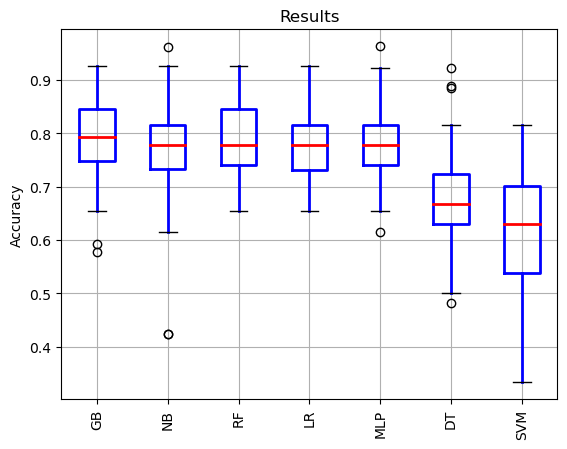

In [8]:
boxplot('accuracy')

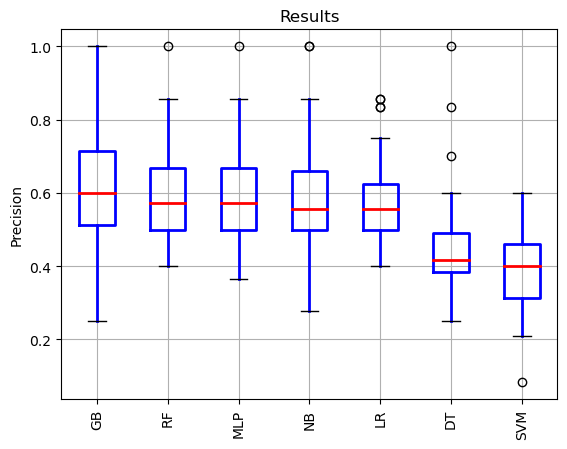

In [9]:
boxplot('precision')

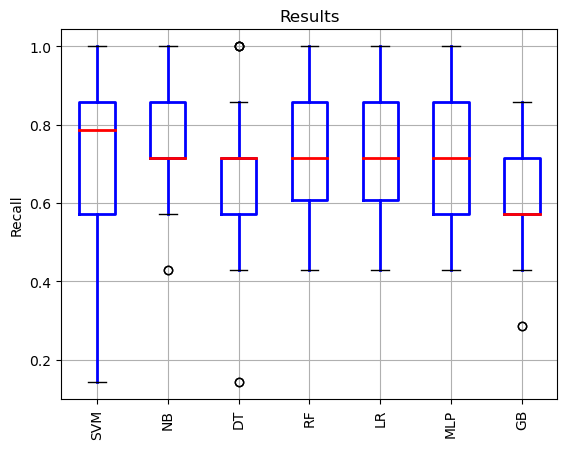

In [10]:
boxplot('recall')

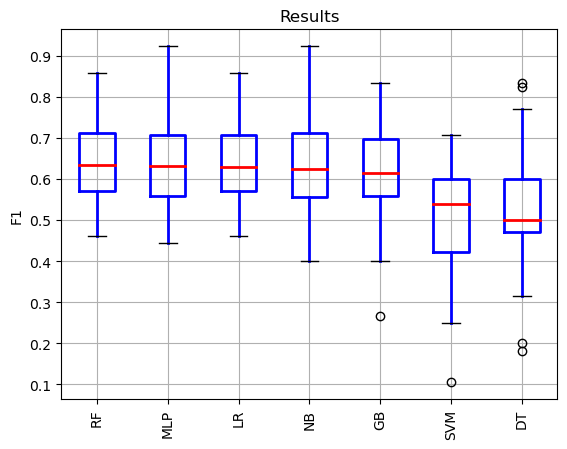

In [11]:
boxplot('f1')

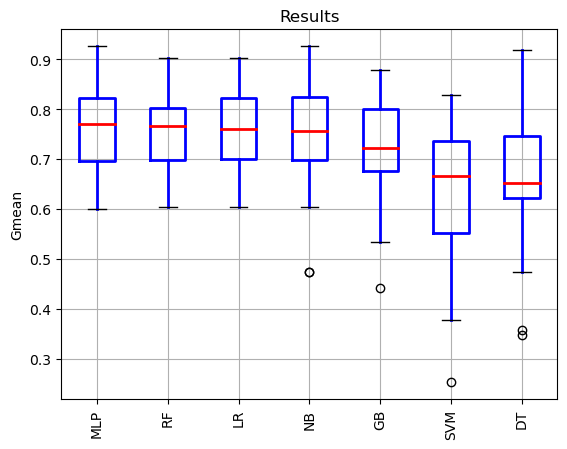

In [12]:
boxplot('gmean')

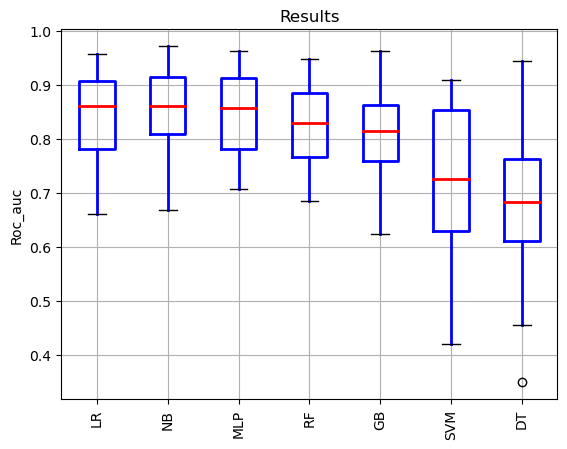

In [13]:
boxplot('roc_auc')

The AUC (Area Under the Curve) is a common metric for evaluating binary classification models, such as predicting whether a patient will survive or not. The AUC measures the model's ability to correctly classify positive (e.g., patients who died) and negative (e.g., patients who survived) examples, and is especially useful when the class distribution is imbalanced. On the other hand, the f1-score is a performance measure that considers both precision and recall of the model. Precision measures the proportion of positive examples correctly classified among all predicted positive examples, while recall measures the proportion of positive examples correctly classified among all actual positive examples. The f1-score is a harmonic mean between precision and recall and can be useful when the balance between precision and recall is important.

## - Confidence Interval

Confidence interval is a statistical measure that indicates the range of likely values for an estimate with a certain degree of confidence. It is commonly used in statistical inference to provide a measure of uncertainty around a point estimate. The confidence interval provides a range of plausible values for the population parameter based on a sample of data.

In [14]:
def mean_confidence_interval(model_name, results, metric='roc_auc', confidence_level=0.95, decimal_place=4):

    results = results[model_name][metric]
    n = len(results)
    mean, sem, std = np.mean(results), stats.sem(results), np.std(results)

    confidence_interval = tuple(map(lambda x: round(x, decimal_place), stats.t.interval(confidence_level, n-1, mean, sem)))

    return pd.DataFrame({
        'Model Name': model_name,
        'Metric': metric,
        'Point Estimate': round(mean, decimal_place),
        'Standard Deviation': round(std, decimal_place),
        'Lower CI': confidence_interval[0],
        'Upper CI': confidence_interval[1],
        'Confidence Level': confidence_level,
        'Sample Size': n
    }, index=[0])

confidence_interval = pd.concat([mean_confidence_interval(model_name, results, metric) for metric in results_df.columns for model_name in models]).reset_index(drop=True)

# Set the metric as index
confidence_interval.set_index('Metric', inplace=True)

In [15]:
confidence_interval.loc['accuracy'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
accuracy,GB,0.7858,0.0766,0.7638,0.8078,0.95,50
accuracy,RF,0.7841,0.0645,0.7656,0.8027,0.95,50
accuracy,MLP,0.7839,0.0698,0.7639,0.8040,0.95,50
accuracy,LR,0.7790,0.0716,0.7584,0.7995,0.95,50
accuracy,NB,0.7710,0.0994,0.7424,0.7995,0.95,50
accuracy,DT,0.6796,0.0917,0.6533,0.7060,0.95,50
accuracy,SVM,0.6231,0.1118,0.5910,0.6552,0.95,50


In [16]:
confidence_interval.loc['precision'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
precision,GB,0.6239,0.1657,0.5764,0.6715,0.95,50
precision,RF,0.5945,0.1251,0.5586,0.6304,0.95,50
precision,MLP,0.5861,0.1193,0.5519,0.6204,0.95,50
precision,NB,0.5783,0.1437,0.5371,0.6196,0.95,50
precision,LR,0.5779,0.1220,0.5428,0.6129,0.95,50
precision,DT,0.4441,0.1319,0.4062,0.4819,0.95,50
precision,SVM,0.3904,0.1114,0.3584,0.4224,0.95,50


In [17]:
confidence_interval.loc['recall'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
recall,LR,0.7429,0.1457,0.7010,0.7847,0.95,50
recall,NB,0.7343,0.1340,0.6958,0.7728,0.95,50
recall,MLP,0.7314,0.1389,0.6915,0.7713,0.95,50
recall,RF,0.7286,0.1378,0.6890,0.7681,0.95,50
recall,SVM,0.7171,0.2128,0.6560,0.7782,0.95,50
recall,DT,0.6714,0.1835,0.6187,0.7241,0.95,50
recall,GB,0.6371,0.1490,0.5944,0.6799,0.95,50


In [18]:
confidence_interval.loc['f1'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
f1,MLP,0.6419,0.1039,0.6121,0.6717,0.95,50
f1,RF,0.6413,0.0896,0.6156,0.6670,0.95,50
f1,LR,0.6404,0.1062,0.6099,0.6709,0.95,50
f1,NB,0.6356,0.1141,0.6029,0.6684,0.95,50
f1,GB,0.6120,0.1139,0.5793,0.6447,0.95,50
f1,DT,0.5226,0.1278,0.4860,0.5593,0.95,50
f1,SVM,0.5003,0.1357,0.4613,0.5393,0.95,50


In [19]:
confidence_interval.loc['gmean'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
gmean,MLP,0.7610,0.0818,0.7375,0.7845,0.95,50
gmean,LR,0.7608,0.0824,0.7371,0.7844,0.95,50
gmean,RF,0.7584,0.0705,0.7381,0.7786,0.95,50
gmean,NB,0.7518,0.0969,0.7239,0.7796,0.95,50
gmean,GB,0.7229,0.0901,0.6970,0.7487,0.95,50
gmean,DT,0.6636,0.1104,0.6319,0.6953,0.95,50
gmean,SVM,0.6397,0.1302,0.6023,0.6770,0.95,50


In [20]:
confidence_interval.loc['roc_auc'].sort_values(by='Point Estimate', ascending=False)

,Model Name,Point Estimate,Standard Deviation,Lower CI,Upper CI,Confidence Level,Sample Size
Metric,,,,,,,
roc_auc,NB,0.8560,0.0737,0.8348,0.8771,0.95,50
roc_auc,MLP,0.8493,0.0701,0.8291,0.8694,0.95,50
roc_auc,LR,0.8447,0.0758,0.8230,0.8665,0.95,50
roc_auc,RF,0.8178,0.0775,0.7955,0.8400,0.95,50
roc_auc,GB,0.8112,0.0786,0.7886,0.8337,0.95,50
roc_auc,SVM,0.7133,0.1482,0.6707,0.7558,0.95,50
roc_auc,DT,0.6843,0.1071,0.6536,0.7151,0.95,50


# STATISTICAL TESTS

## Normality Test

The normality test is important because many statistical methods assume that data are normally distributed. If a distribution is not normal, these methods may not be appropriate or require adjustments to work correctly.

In [21]:
def normality_test(results, metric):
    normality_dict = {}
    for model_name in models:
        score_values = results[model_name][metric]
        stat, p = shapiro(score_values)
        normality_dict[model_name] = {'Statistic': stat, 'p-value': p, 'Normality': p < ALPHA}
    
    return pd.DataFrame.from_dict(normality_dict, orient='index').assign(Metric=metric)

normality_test = pd.concat([normality_test(results, metric) for metric in results_df.columns], axis=0)

In [22]:
normality_test.query('Metric == "accuracy"')

,Statistic,p-value,Normality,Metric
NB,0.872109,0.000065,True,accuracy
GB,0.941441,0.015368,True,accuracy
DT,0.964569,0.138095,False,accuracy
RF,0.970596,0.244689,False,accuracy
SVM,0.970391,0.240056,False,accuracy
LR,0.959035,0.080987,False,accuracy
MLP,0.986372,0.828605,False,accuracy


In [23]:
normality_test.query('Metric == "precision"')

,Statistic,p-value,Normality,Metric
NB,0.935188,0.008731,True,precision
GB,0.974769,0.357592,False,precision
DT,0.831699,0.000005,True,precision
RF,0.926713,0.004158,True,precision
SVM,0.974264,0.341958,False,precision
LR,0.933327,0.007400,True,precision
MLP,0.949669,0.033065,True,precision


In [24]:
normality_test.query('Metric == "recall"')

,Statistic,p-value,Normality,Metric
NB,0.904283,0.000667,True,recall
GB,0.903825,0.000644,True,recall
DT,0.910931,0.001126,True,recall
RF,0.895090,0.000332,True,recall
SVM,0.899447,0.000461,True,recall
LR,0.888356,0.000203,True,recall
MLP,0.881893,0.000128,True,recall


In [25]:
normality_test.query('Metric == "f1"')

,Statistic,p-value,Normality,Metric
NB,0.989588,0.936091,False,f1
GB,0.973990,0.333708,False,f1
DT,0.956234,0.061840,False,f1
RF,0.977442,0.449829,False,f1
SVM,0.942731,0.017301,True,f1
LR,0.965715,0.154144,False,f1
MLP,0.977995,0.470853,False,f1


In [26]:
normality_test.query('Metric == "roc_auc"')

,Statistic,p-value,Normality,Metric
NB,0.961380,0.101555,False,roc_auc
GB,0.981116,0.599904,False,roc_auc
DT,0.979122,0.515544,False,roc_auc
RF,0.952789,0.044462,True,roc_auc
SVM,0.925223,0.003661,True,roc_auc
LR,0.950212,0.034806,True,roc_auc
MLP,0.949125,0.031409,True,roc_auc


## Friedman

The Friedman test is used when the data are paired, such as when comparing the same set of subjects under different conditions. It tests the null hypothesis that the groups have the same distribution, and the alternative hypothesis that at least one group has a different distribution. The test statistic is calculated by ranking the data within each group and summing the ranks for each group. The test statistic is then compared to a chi-squared distribution with degrees of freedom equal to the number of groups minus one. If the p-value is less than the chosen significance level, then the null hypothesis is rejected, and it can be concluded that there is a significant difference between the groups.

In [27]:
# Define scores
scores = [results[key][metric] for key in results.keys() for metric in results_df.columns]

# Create a dictionary of statistics
data = {'metric': [], 'statistic': [], 'p-value': [], 'significant difference': []}

# Loop through the metrics
for metric in results_df.columns:
    metric_scores = scores[:len(results.keys())]
    scores = scores[len(results.keys()):]
    stat, p_value = friedmanchisquare(*metric_scores)
    data['metric'].append(metric)
    data['statistic'].append(stat)
    data['p-value'].append(p_value)
    if p_value < ALPHA:
        data['significant difference'].append('Yes')
    else:
        data['significant difference'].append('No')

# Create the dataframe
friedman = pd.DataFrame(data)

# Set the metric as index
friedman.set_index('metric', inplace=True)

# Show the dataframe
friedman

,statistic,p-value,significant difference
metric,,,
accuracy,178.648375,6.570971e-36,Yes
f1,146.952937,3.409272e-29,Yes
gmean,169.886819,4.753350e-34,Yes
precision,215.506643,9.445368e-44,Yes
recall,104.382577,3.050815e-20,Yes
roc_auc,222.540735,2.988327e-45,Yes


For all the metrics (accuracy, f1, precision, recall, and roc_auc), the p-value is less than the commonly adopted significance level of 0.05. Therefore, we can assert that there are statistically significant differences between the samples for all these metrics.

The fact that the p-value is very close to zero provides strong evidence against the null hypothesis that there are no differences between the samples. This suggests that at least one of the samples is significantly different from the others in terms of each evaluated metric.

## Wilcoxon-Mann-Whitney

The Wilcoxon-Mann-Whitney test is a nonparametric test used to determine if two independent samples were drawn from populations with the same distribution. It is used as an alternative to the two-sample t-test when the assumptions of normality and equal variances are not met.

In [28]:
def plot_wilcoxon_heatmap(metric):

    MODEL_NAMES = list(models.keys())

    n_models = len(MODEL_NAMES)

    # Calculate the p-value of the Wilcoxon test for each pair of classifiers
    wilcoxon_matrix = np.zeros((n_models, n_models))
    for i, clf1 in enumerate(MODEL_NAMES):
        for j, clf2 in enumerate(MODEL_NAMES[i+1:], i+1):
            _, p_value = wilcoxon(results[clf1][metric], results[clf2][metric])
            wilcoxon_matrix[i, j] = p_value

    # Plot the matrix using a color scale
    fig, ax = plt.subplots()
    im = ax.imshow(wilcoxon_matrix, cmap='coolwarm', vmin=0, vmax=1)

    # Add classifier labels
    ax.set_xticks(range(n_models))
    ax.set_yticks(range(n_models))
    ax.set_xticklabels(MODEL_NAMES, fontsize=8, rotation=90)
    ax.set_yticklabels(MODEL_NAMES, fontsize=8)

    # Add p-values to each cell
    for i in range(n_models):
        for j in range(i+1, n_models):
            p_value = wilcoxon_matrix[i, j]
            text_color = 'white' if p_value < ALPHA else 'black'
            text = ax.text(j, i, '{:.2f}'.format(p_value), ha='center', va='center', color=text_color, fontsize=6, fontweight='bold' if p_value < ALPHA else 'normal')

    # Configure color bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('p-value', rotation=-90, va='bottom', fontsize=10)

    # Set plot title
    plt.title('Wilcoxon Test - {}'.format(metric), fontsize=12)

    # Display plot
    plt.show()

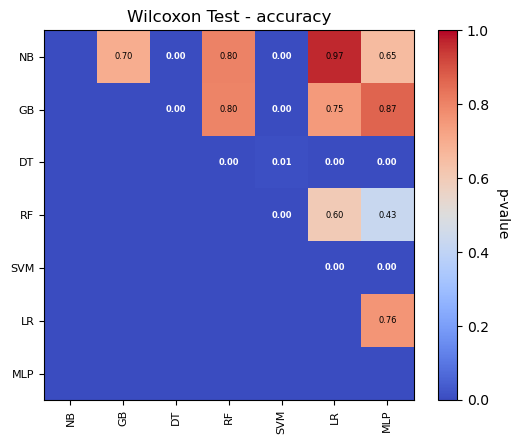

In [29]:
plot_wilcoxon_heatmap('accuracy')

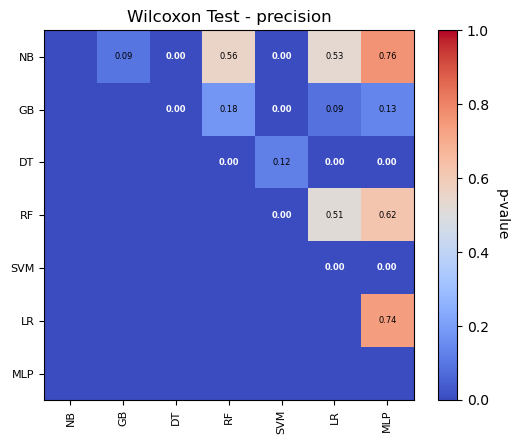

In [30]:
plot_wilcoxon_heatmap('precision')

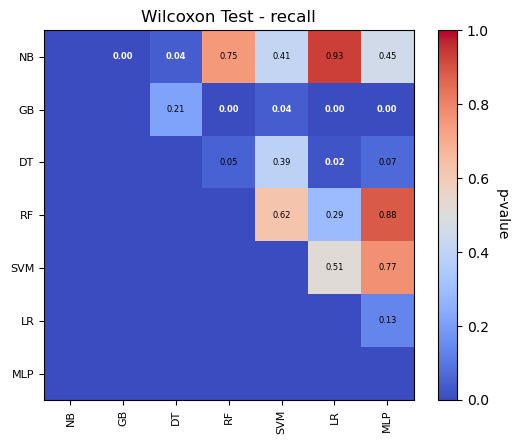

In [31]:
plot_wilcoxon_heatmap('recall')

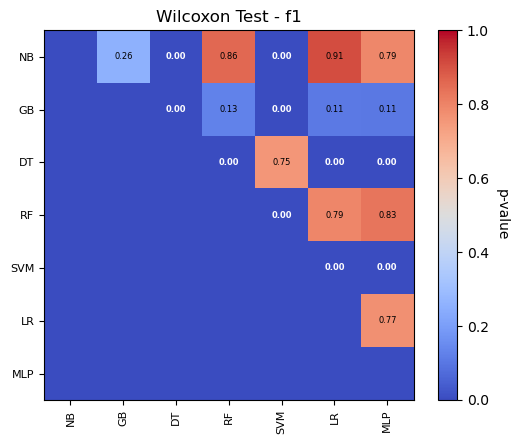

In [32]:
plot_wilcoxon_heatmap('f1')

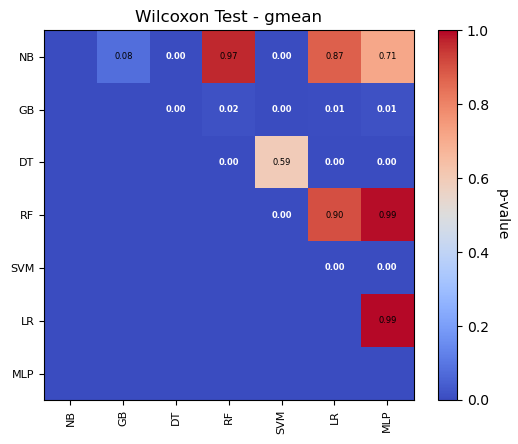

In [33]:
plot_wilcoxon_heatmap('gmean')

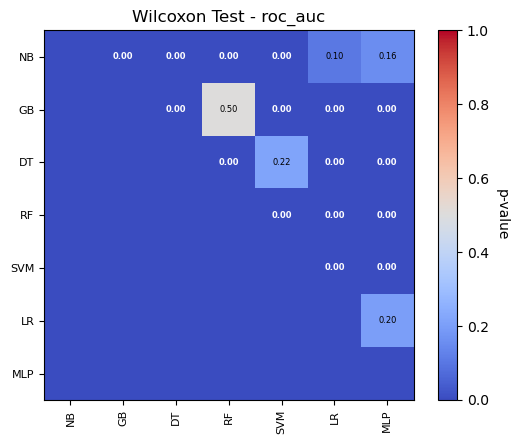

In [34]:
plot_wilcoxon_heatmap('roc_auc')